# AI Masters 2024, DL course, HW-2

## Building a NN for `tiny-imagenet-200` from scratch

### Подготовка данных, среды и создание первой модели, идентичной модели с семинара 5, но с аугментацией и немного измененными параметрами.

In [3]:
# Determine the locations of auxiliary libraries and datasets.
# `AUX_DATA_ROOT` is where 'tiny-imagenet.zip' is.

# Detect if we are in Google Colaboratory
try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

from pathlib import Path
if IN_COLAB:
    google.colab.drive.mount("/content/drive")

    # Change this if you created the shortcut in a different location
    AUX_DATA_ROOT = Path("/content/drive/MyDrive/ML3_2024/HW2")

    assert AUX_DATA_ROOT.is_dir(), "Have you forgot to 'Add a shortcut to Drive'?"

    import sys
    sys.path.append(str(AUX_DATA_ROOT))
else:
    # Change this if you created the shortcut in a different location
    AUX_DATA_ROOT = Path("/kaggle/working")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import os
from urllib.request import urlretrieve

def download_dataset(path, url='http://cs231n.stanford.edu/tiny-imagenet-200.zip'):
    dataset_name = 'tiny-imagenet-200'

    if os.path.exists(os.path.join(path, dataset_name, "val", "n01443537")):
        print("%s already exists, skipping download" % os.path.join(path, dataset_name))
        return
    elif not os.path.exists(os.path.join(path, 'tiny-imagenet-200' + ".zip")):
        print("Dataset doesn't exist or is broken, downloading it")
        urlretrieve(url, os.path.join(path, dataset_name + ".zip"))

    import zipfile
    with zipfile.ZipFile(os.path.join(path, 'tiny-imagenet-200' + ".zip"), 'r') as archive:
        archive.extractall()

    # move validation images to subfolders by class
    val_root = os.path.join(".", dataset_name, "val")
    with open(os.path.join(val_root, "val_annotations.txt"), 'r') as f:
        for image_filename, class_name, _, _, _, _ in map(str.split, f):
            class_path = os.path.join(val_root, class_name)
            os.makedirs(class_path, exist_ok=True)
            os.rename(
                os.path.join(val_root, "images", image_filename),
                os.path.join(class_path, image_filename)
            )

    os.rmdir(os.path.join(val_root, "images"))
    os.remove(os.path.join(val_root, "val_annotations.txt"))

In [5]:
# Put training and validation images in `./tiny-imagenet-200/train` and `./tiny-imagenet-200/val`:
download_dataset(AUX_DATA_ROOT)

Dataset doesn't exist or is broken, downloading it


In [6]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T

import numpy as np

from PIL import Image
import matplotlib.pyplot as plt
%config InlineBackend.figure_format='retina'

from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix

from glob import glob

import tqdm

import imgaug as ia
import imgaug.augmenters as iaa

In [7]:
class TINDataset(Dataset):
    def __init__(self, root_dir, split="train", transform=None, augmentation=None):
        """
        Параметры:
        - root_dir: базовый каталог, в котором хранится 'tiny-imagenet-200'
        - split: тип выборки ('train', 'val' или 'test')
        - transform: преобразования для изображений
        - augmentation: аугментации для изображений
        """
        self.root_dir = root_dir # /content/tiny-imagenet-200
        self.split = split
        self.transform = transform
        self.augmentation = augmentation

        self.data_dir = os.path.join(self.root_dir, split) # e.g. /content/tiny-imagenet-200/train

        if split in ["train", "val"]:
            self.image_paths = []
            self.labels = []

            class_dirs = sorted(os.listdir(self.data_dir)) # e.g. /content/tiny-imagenet-200/train/n01443537
            self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(class_dirs)} # e.g. { n01443537 : 0, n01629819 : 1, ... }

            for cls_name in class_dirs:
                cls_dir = os.path.join(self.data_dir, cls_name) # e.g. /content/tiny-imagenet-200/train/n01443537
                if split == "train":
                    cls_dir = os.path.join(cls_dir, "images") # e.g. /content/tiny-imagenet-200/train/n01443537/images

                cls_image_paths = glob(os.path.join(cls_dir, "*"))
                self.image_paths.extend(cls_image_paths)
                label = self.class_to_idx[cls_name]
                self.labels.extend([label] * len(cls_image_paths))

        elif split == "test":
            test_data_dir = os.path.join(self.data_dir, "images")
            self.image_paths = glob(os.path.join(test_data_dir, "*"))
            self.labels = [-1] * len(self.image_paths)  # метки неизвестны

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")

        image = np.array(image)

        if self.augmentation is not None:
            image = self.augmentation.augment_image(image)

        image = Image.fromarray(image)

        if self.transform is not None:
            image = self.transform(image)

        label = torch.tensor(self.labels[idx])
        return image, label

In [ ]:
def calculate_mean_std(dataset):
    """
    Функция для вычисления среднего и стандартного отклонения для изображений в датасете.
    """
    loader = DataLoader(dataset, batch_size=64, shuffle=False, num_workers=2)

    # Инициализируем суммы для накопления значений и квадратов значений
    mean = torch.zeros(3)
    sum_squared_diff = torch.zeros(3)

    for images, _ in loader:
        mean += images.mean(dim=(2,3)).sum(0)  # Считаем среднее по каждому каналу и суммируем по всем батчам

    mean = mean / len(dataset)

    for images, _ in loader:
        diff = images - mean.view(1, 3, 1, 1)  # Приводим mean к нужной форме
        sum_squared_diff += (diff ** 2).mean(dim=(2,3)).sum(0)  # Среднеквадратичное отклонение по каждому каналу и суммируем по всем батчам

    std = (sum_squared_diff / len(dataset)).sqrt()

    return mean.tolist(), std.tolist()

Сначала один раз сами посчитаем статистики среднего и std, создав экземпляр датасета, а затем создадим уже настоящий, нормализованный на "правильные" статистики.

In [ ]:
root_dir = Path("/content/tiny-imagenet-200") if IS_COLAB else: Path("/kaggle/working/tiny-imagenet-200")

train_dataset_mean_std = TINDataset(root_dir=root_dir, split="train", transform=T.ToTensor())

In [ ]:
train_mean, train_std = calculate_mean_std(train_dataset_mean_std)

In [ ]:
train_mean, train_std

([0.4802369773387909, 0.44806739687919617, 0.39750364422798157],
 [0.27643632888793945, 0.2688632905483246, 0.2815898656845093])

In [9]:
augmentation = iaa.Sequential([
    iaa.Fliplr(0.5),
    iaa.Flipud(0.2),
    iaa.Sometimes(0.5, iaa.GaussianBlur(sigma=(0, 2.0))),
    iaa.Sometimes(0.5, iaa.CropAndPad(percent=(-0.1, 0.2), pad_mode=ia.ALL, pad_cval=(0, 255))),
    iaa.Sometimes(0.5, iaa.Affine(
        scale={"x": (0.8, 1.5), "y": (0.8, 1.5)},
        translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
        rotate=(-45, 45),
        shear=(-16, 16),
        order=[0, 1],
        cval=(0, 255),
        mode=ia.ALL
    )),
    iaa.Sometimes(0.5, iaa.CoarseDropout((0.03, 0.15), size_percent=(0.02, 0.05), per_channel=0.2)),
    iaa.Sometimes(0.5, iaa.Multiply((0.8, 1.2), per_channel=0.2)),
    iaa.Sometimes(0.5, iaa.LinearContrast((0.75, 1.5), per_channel=0.5)),
], random_order=True)

transform = T.Compose([
    T.ToTensor(),
    T.Normalize([0.4802, 0.4481, 0.3975], [0.2764, 0.2689, 0.2816])
])

In [10]:
root_dir = Path("/content/tiny-imagenet-200") if IS_COLAB else: Path("/kaggle/working/tiny-imagenet-200")

train_dataset = TINDataset(root_dir=root_dir, split="train", transform=transform, augmentation=augmentation)
val_dataset = TINDataset(root_dir=root_dir, split="val", transform=transform)

In [ ]:
def tensor_to_image(tensor, mean=[0.4802, 0.4481, 0.3975], std=[0.2764, 0.2689, 0.2816]):
    mean_tensor = torch.tensor(mean)[None, None, :]
    std_tensor = torch.tensor(std)[None, None, :]

    image = tensor.permute(1,2,0) * std_tensor + mean_tensor
    return image

In [ ]:
import random

def visualize_sample_images(dataset, num_classes=4, images_per_class=8):
    """
    Визуализация случайных образцов изображений из датасета.

    Параметры:
    - dataset: объект датасета
    - num_classes: количество классов для отображения
    - images_per_class: количество изображений для каждого класса
    """
    selected_classes = random.sample(list(dataset.class_to_idx.keys()), num_classes)
    sample_images = {}

    for class_name in selected_classes:
        class_idx = dataset.class_to_idx[class_name]
        class_images = [img for idx, img in enumerate(dataset.image_paths) if dataset.labels[idx] == class_idx]
        sample_images[class_name] = random.sample(class_images, min(images_per_class, len(class_images)))

    fig, axes = plt.subplots(num_classes, images_per_class, figsize=(7 * images_per_class / num_classes, 7))

    for idx, (class_name, images) in enumerate(sample_images.items()):
        for img in images:
            axes[idx, images.index(img)].imshow(Image.open(img))

        axes[idx, 0].set_ylabel(class_name)

    plt.tight_layout()
    plt.show()

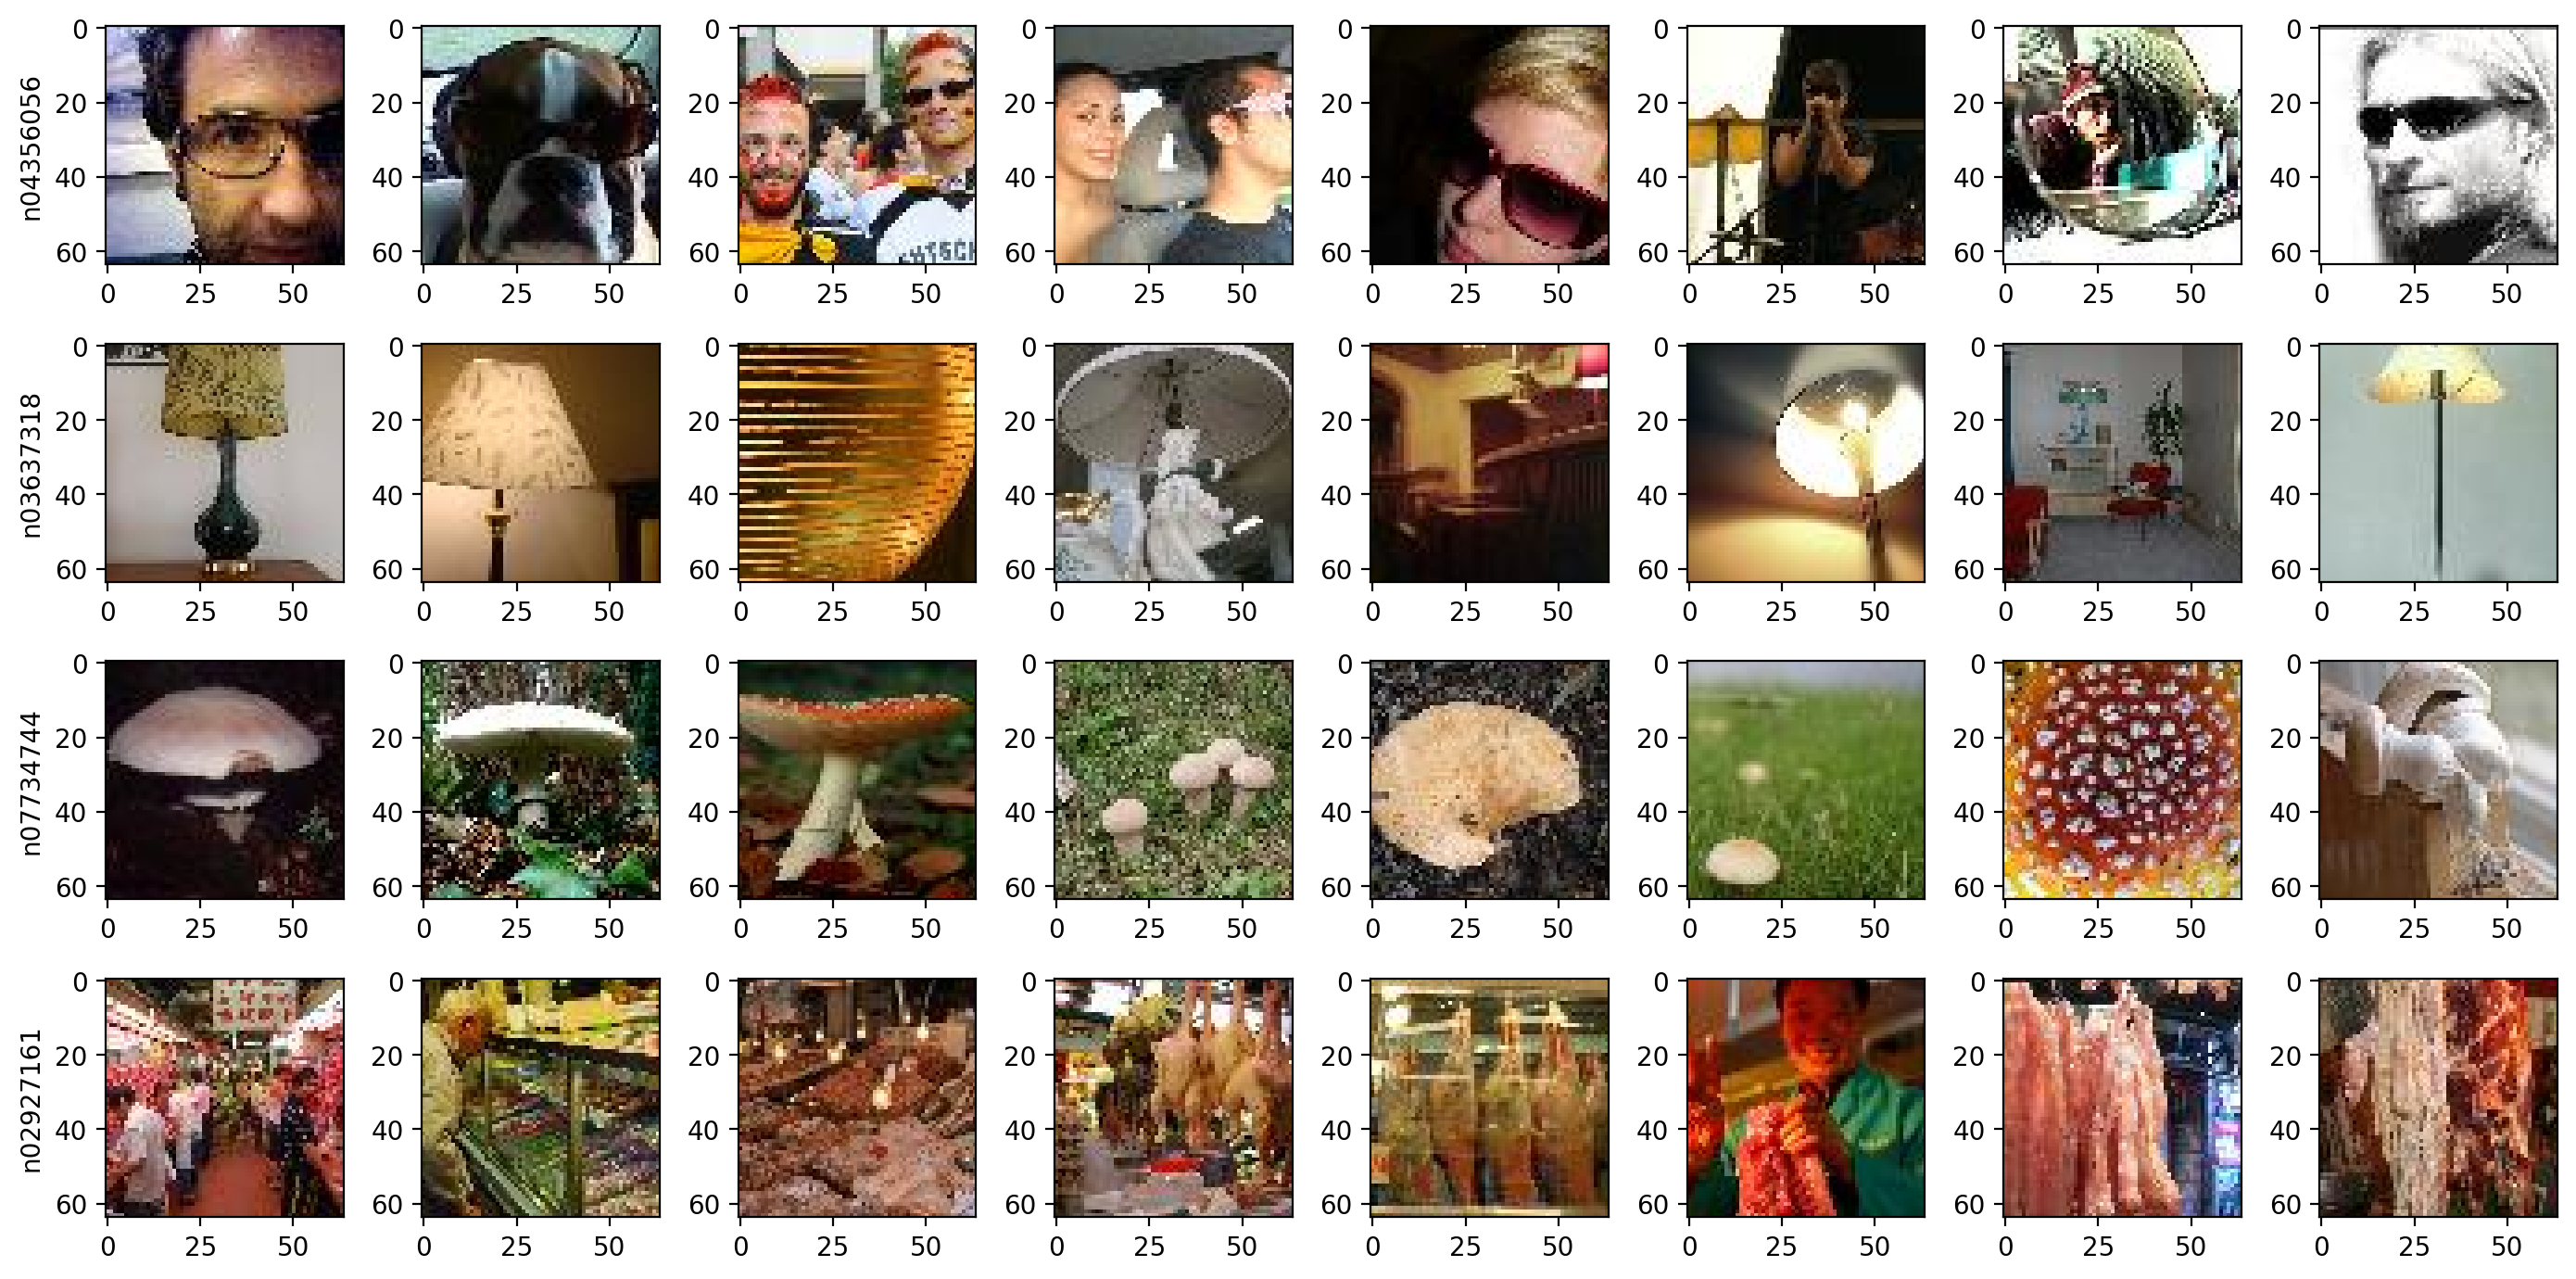

In [ ]:
visualize_sample_images(train_dataset, 4, 8)

In [11]:
num_workers = os.cpu_count()
num_workers

2

In [12]:
config_0_0 = {
    "learning_rate": 3e-4,
    "weight_decay": 0.01,
    "batch_size": 50,
    "num_epochs": 30,
    "optimizer": torch.optim.AdamW,
    "scheduler": torch.optim.lr_scheduler.LambdaLR
}

train_loader_0 = DataLoader(
    train_dataset,
    batch_size=config_0_0["batch_size"],
    shuffle=True,
    drop_last=True,
    num_workers=num_workers,
    pin_memory=True,
    prefetch_factor=4,
)

val_loader_0 = DataLoader(
    val_dataset,
    batch_size=config_0_0["batch_size"],
    shuffle=False,
    drop_last=False,
    num_workers=num_workers,
    pin_memory=True,
    prefetch_factor=4,
)

In [13]:
class CNNBlock(nn.Module):
    def __init__(self, in_channels=3, out_channels=32, kernel_size=3, padding=1, stride=1, pool=False, conv=True):
        super(CNNBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size, padding, stride, bias=False) if conv else nn.Identity()
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool= nn.MaxPool2d((2, 2)) if pool else nn.Identity()

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        return x

In [ ]:
class Model_0(nn.Module):
    def __init__(self, num_classes=200):
        super(Model_0, self).__init__()

        self.model = nn.Sequential(
            CNNBlock(3, 32),
            CNNBlock(32, 32, pool=True),  # 32x32
            CNNBlock(32, 64),
            CNNBlock(64, 64, pool=True),  # 16x16
            CNNBlock(64, 128),
            CNNBlock(128, 128, pool=True),  # 8x8
            CNNBlock(128, 256),
            CNNBlock(256, 256, pool=True),  # 4x4
            nn.AdaptiveAvgPool2d((1, 1)),  # B x 256 x 1 x 1
            nn.Flatten(),                  # B x 256
            nn.Linear(256, num_classes)     # output layer
        )

    def forward(self, x):
        return self.model(x)

In [14]:
model_0 = Model_0()

In [15]:
model_0

Sequential(
  (0): CNNBlock(
    (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): Identity()
  )
  (1): CNNBlock(
    (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (2): CNNBlock(
    (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): Identity()
  )
  (3): CNNBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, 

In [16]:
def save_checkpoint(model, optimizer, scheduler, epoch, loss, filename):
    """Сохранение состояния модели, оптимизатора, номера эпохи и потерь в файл."""
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'loss': loss,
    }
    with open(filename, "wb") as fp:
        torch.save(checkpoint, fp)

def load_checkpoint(model,optimizer,scheduler,device,filename):
    """Загрузка состояния модели, оптимизатора, номера эпохи и потерь из файла."""
    with open(filename, "rb") as fp:
        checkpoint = torch.load(fp, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    return epoch, loss

In [17]:
import wandb

wandb.login()

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
wandb.init(
    # set the wandb project where this run will be logged
    project="HW2",
    name="model_0",
    reinit=True,
    # track hyperparameters and run metadata
    config=config_0_0,
)

wandb: Currently logged in as: alexx_ponomarenko (alexx_ponomarenko-m-v-lomonosovmoscow-state-university). Use `wandb login --relogin` to force relogin


In [18]:
def run_epoch(stage, model, dataloader, loss_fn, optimizer, scheduler, epoch, device):
    # v NOTE THIS v
    if stage == "train":
        model.train()
        torch.set_grad_enabled(True)
    else:
        torch.set_grad_enabled(False)
        model.eval()
    # ^ NOTE THIS ^

    model = model.to(device)
    num_steps = len(dataloader)
    losses = []

    total_correct = 0
    total_samples = 0

    for i, batch in enumerate(tqdm.tqdm(dataloader, total=len(dataloader), desc=f"epoch: {str(epoch).zfill(3)} | {stage:5}")):
        xs, ys_true = batch

        ys_pred = model(xs.to(device))
        loss = loss_fn(ys_pred, ys_true.to(device))

        ys_pred = ys_pred.to(device="cpu")
        _, predicted_labels = torch.max(ys_pred, dim=1)
        total_correct += (predicted_labels == ys_true).sum().item()
        total_samples += ys_true.size(0)

        if stage == "train":
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            if scheduler is not None:
                scheduler.step()
            # логгируем номер шага при обучении
            wandb.log({
                "training_step": i + num_steps * epoch,
                "lr": optimizer.param_groups[0]["lr"],
                "loss": loss,
            })

        losses.append(loss.detach().cpu().item())

    epoch_accuracy = total_correct / total_samples

    return np.mean(losses), epoch_accuracy

In [19]:
def run_experiment(
    model, dataloader_train, dataloader_val, loss_fn, optimizer, scheduler, num_epochs, device, output_dir, start_epoch=0, best_val=np.inf
):
    train_losses = []
    val_losses = []

    train_accuracies = []
    val_accuracies = []

    best_val_loss = best_val
    best_val_loss_epoch = -1
    best_val_loss_fn = None

    os.makedirs(output_dir, exist_ok=True)

    for epoch in range(start_epoch, num_epochs):
        train_loss, train_accuracy = run_epoch("train", model, dataloader_train, loss_fn, optimizer, scheduler, epoch, device)
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        val_loss, val_accuracy = run_epoch("val", model, dataloader_val, loss_fn, optimizer, None, epoch, device)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        wandb.log({"epoch_loss_train": train_loss, "epoch_loss_val": val_loss, "epoch_accuracy_train": train_accuracy, "epoch_accuracy_val": val_accuracy, "epoch": epoch})

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_val_loss_epoch = epoch

            output_fn = os.path.join(output_dir, f"epoch={str(epoch).zfill(2)}_valloss={best_val_loss:.3f}.pth.tar")
            save_checkpoint(model, optimizer, scheduler, epoch, val_loss, output_fn)
            print(f"New checkpoint saved to {output_fn}\n")

            best_val_loss_fn = output_fn

    print(f"Best val_loss = {best_val_loss:.3f} reached at epoch {best_val_loss_epoch}")
    load_checkpoint(model, optimizer, scheduler, device, best_val_loss_fn)

    return train_losses, val_losses, train_accuracies, val_accuracies, best_val_loss, model

In [20]:
loss_fn = nn.CrossEntropyLoss()

In [ ]:
optimizer_0 = config_0_0['optimizer'](model_0.parameters(), lr=config_0_0['learning_rate'], weight_decay=config_0_0['weight_decay'])
scheduler_0 = config_0_0['scheduler'](optimizer_0, lr_lambda=lambda epoch: 1.0)

In [21]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(device)

cuda:0


In [ ]:
train_losses_0, val_losses_0, train_accuracies_0, val_accuracies_0, best_val_loss_0, model_0 = run_experiment(
    model_0,
    train_loader_0,
    val_loader_0,
    loss_fn,
    optimizer_0,
    scheduler_0,
    config_0_0["num_epochs"],
    device,
    os.path.join(AUX_DATA_ROOT, "checkpoints_0"),
)

epoch: 000 | train: 100%|██████████| 2000/2000 [06:10<00:00,  5.39it/s]
epoch: 000 | val  : 100%|██████████| 200/200 [00:06<00:00, 32.06it/s]


New checkpoint saved to /content/drive/MyDrive/ML3_2024/HW2/checkpoints_0/epoch=00_valloss=4.273.pth.tar



epoch: 001 | train: 100%|██████████| 2000/2000 [06:04<00:00,  5.49it/s]
epoch: 001 | val  : 100%|██████████| 200/200 [00:10<00:00, 19.53it/s]


New checkpoint saved to /content/drive/MyDrive/ML3_2024/HW2/checkpoints_0/epoch=01_valloss=3.892.pth.tar



epoch: 002 | train: 100%|██████████| 2000/2000 [05:22<00:00,  6.20it/s]
epoch: 002 | val  : 100%|██████████| 200/200 [00:07<00:00, 26.50it/s]


New checkpoint saved to /content/drive/MyDrive/ML3_2024/HW2/checkpoints_0/epoch=02_valloss=3.575.pth.tar



epoch: 003 | train: 100%|██████████| 2000/2000 [05:37<00:00,  5.92it/s]
epoch: 003 | val  : 100%|██████████| 200/200 [00:05<00:00, 33.58it/s]


New checkpoint saved to /content/drive/MyDrive/ML3_2024/HW2/checkpoints_0/epoch=03_valloss=3.392.pth.tar



epoch: 004 | train: 100%|██████████| 2000/2000 [05:47<00:00,  5.75it/s]
epoch: 004 | val  : 100%|██████████| 200/200 [00:09<00:00, 21.39it/s]


New checkpoint saved to /content/drive/MyDrive/ML3_2024/HW2/checkpoints_0/epoch=04_valloss=3.200.pth.tar



epoch: 005 | train: 100%|██████████| 2000/2000 [05:24<00:00,  6.17it/s]
epoch: 005 | val  : 100%|██████████| 200/200 [00:05<00:00, 34.20it/s]


New checkpoint saved to /content/drive/MyDrive/ML3_2024/HW2/checkpoints_0/epoch=05_valloss=3.080.pth.tar



epoch: 006 | train: 100%|██████████| 2000/2000 [05:49<00:00,  5.72it/s]
epoch: 006 | val  : 100%|██████████| 200/200 [00:08<00:00, 23.50it/s]


New checkpoint saved to /content/drive/MyDrive/ML3_2024/HW2/checkpoints_0/epoch=06_valloss=2.974.pth.tar



epoch: 007 | train: 100%|██████████| 2000/2000 [05:19<00:00,  6.27it/s]
epoch: 007 | val  : 100%|██████████| 200/200 [00:06<00:00, 32.73it/s]


New checkpoint saved to /content/drive/MyDrive/ML3_2024/HW2/checkpoints_0/epoch=07_valloss=2.856.pth.tar



epoch: 008 | train: 100%|██████████| 2000/2000 [05:16<00:00,  6.33it/s]
epoch: 008 | val  : 100%|██████████| 200/200 [00:06<00:00, 28.66it/s]
epoch: 009 | train: 100%|██████████| 2000/2000 [05:21<00:00,  6.22it/s]
epoch: 009 | val  : 100%|██████████| 200/200 [00:05<00:00, 34.15it/s]


New checkpoint saved to /content/drive/MyDrive/ML3_2024/HW2/checkpoints_0/epoch=09_valloss=2.809.pth.tar



epoch: 010 | train: 100%|██████████| 2000/2000 [05:20<00:00,  6.24it/s]
epoch: 010 | val  : 100%|██████████| 200/200 [00:07<00:00, 25.03it/s]


New checkpoint saved to /content/drive/MyDrive/ML3_2024/HW2/checkpoints_0/epoch=10_valloss=2.721.pth.tar



epoch: 011 | train: 100%|██████████| 2000/2000 [05:17<00:00,  6.31it/s]
epoch: 011 | val  : 100%|██████████| 200/200 [00:05<00:00, 34.01it/s]


New checkpoint saved to /content/drive/MyDrive/ML3_2024/HW2/checkpoints_0/epoch=11_valloss=2.674.pth.tar



epoch: 012 | train: 100%|██████████| 2000/2000 [05:18<00:00,  6.28it/s]
epoch: 012 | val  : 100%|██████████| 200/200 [00:05<00:00, 34.51it/s]


New checkpoint saved to /content/drive/MyDrive/ML3_2024/HW2/checkpoints_0/epoch=12_valloss=2.616.pth.tar



epoch: 013 | train: 100%|██████████| 2000/2000 [05:15<00:00,  6.34it/s]
epoch: 013 | val  : 100%|██████████| 200/200 [00:05<00:00, 34.70it/s]


New checkpoint saved to /content/drive/MyDrive/ML3_2024/HW2/checkpoints_0/epoch=13_valloss=2.562.pth.tar



epoch: 014 | train: 100%|██████████| 2000/2000 [05:16<00:00,  6.32it/s]
epoch: 014 | val  : 100%|██████████| 200/200 [00:08<00:00, 22.56it/s]
epoch: 015 | train: 100%|██████████| 2000/2000 [05:11<00:00,  6.41it/s]
epoch: 015 | val  : 100%|██████████| 200/200 [00:08<00:00, 23.52it/s]


New checkpoint saved to /content/drive/MyDrive/ML3_2024/HW2/checkpoints_0/epoch=15_valloss=2.496.pth.tar



epoch: 016 | train: 100%|██████████| 2000/2000 [05:18<00:00,  6.28it/s]
epoch: 016 | val  : 100%|██████████| 200/200 [00:05<00:00, 34.63it/s]
epoch: 017 | train: 100%|██████████| 2000/2000 [05:13<00:00,  6.39it/s]
epoch: 017 | val  : 100%|██████████| 200/200 [00:05<00:00, 34.77it/s]


New checkpoint saved to /content/drive/MyDrive/ML3_2024/HW2/checkpoints_0/epoch=17_valloss=2.429.pth.tar



epoch: 018 | train: 100%|██████████| 2000/2000 [05:19<00:00,  6.26it/s]
epoch: 018 | val  : 100%|██████████| 200/200 [00:07<00:00, 27.81it/s]


New checkpoint saved to /content/drive/MyDrive/ML3_2024/HW2/checkpoints_0/epoch=18_valloss=2.417.pth.tar



epoch: 019 | train: 100%|██████████| 2000/2000 [05:15<00:00,  6.34it/s]
epoch: 019 | val  : 100%|██████████| 200/200 [00:08<00:00, 24.81it/s]
epoch: 020 | train: 100%|██████████| 2000/2000 [05:19<00:00,  6.26it/s]
epoch: 020 | val  : 100%|██████████| 200/200 [00:06<00:00, 32.65it/s]


New checkpoint saved to /content/drive/MyDrive/ML3_2024/HW2/checkpoints_0/epoch=20_valloss=2.382.pth.tar



epoch: 021 | train: 100%|██████████| 2000/2000 [05:16<00:00,  6.32it/s]
epoch: 021 | val  : 100%|██████████| 200/200 [00:07<00:00, 28.39it/s]
epoch: 022 | train: 100%|██████████| 2000/2000 [05:15<00:00,  6.34it/s]
epoch: 022 | val  : 100%|██████████| 200/200 [00:08<00:00, 22.73it/s]


New checkpoint saved to /content/drive/MyDrive/ML3_2024/HW2/checkpoints_0/epoch=22_valloss=2.353.pth.tar



epoch: 023 | train: 100%|██████████| 2000/2000 [05:13<00:00,  6.38it/s]
epoch: 023 | val  : 100%|██████████| 200/200 [00:05<00:00, 33.92it/s]


New checkpoint saved to /content/drive/MyDrive/ML3_2024/HW2/checkpoints_0/epoch=23_valloss=2.337.pth.tar



epoch: 024 | train: 100%|██████████| 2000/2000 [05:15<00:00,  6.34it/s]
epoch: 024 | val  : 100%|██████████| 200/200 [00:05<00:00, 34.04it/s]


New checkpoint saved to /content/drive/MyDrive/ML3_2024/HW2/checkpoints_0/epoch=24_valloss=2.328.pth.tar



epoch: 025 | train: 100%|██████████| 2000/2000 [05:14<00:00,  6.36it/s]
epoch: 025 | val  : 100%|██████████| 200/200 [00:07<00:00, 25.98it/s]


New checkpoint saved to /content/drive/MyDrive/ML3_2024/HW2/checkpoints_0/epoch=25_valloss=2.324.pth.tar



epoch: 026 | train: 100%|██████████| 2000/2000 [05:09<00:00,  6.47it/s]
epoch: 026 | val  : 100%|██████████| 200/200 [00:09<00:00, 20.02it/s]


New checkpoint saved to /content/drive/MyDrive/ML3_2024/HW2/checkpoints_0/epoch=26_valloss=2.278.pth.tar



epoch: 027 | train: 100%|██████████| 2000/2000 [05:10<00:00,  6.45it/s]
epoch: 027 | val  : 100%|██████████| 200/200 [00:06<00:00, 32.02it/s]


New checkpoint saved to /content/drive/MyDrive/ML3_2024/HW2/checkpoints_0/epoch=27_valloss=2.267.pth.tar



epoch: 028 | train: 100%|██████████| 2000/2000 [05:14<00:00,  6.36it/s]
epoch: 028 | val  : 100%|██████████| 200/200 [00:05<00:00, 34.86it/s]
epoch: 029 | train: 100%|██████████| 2000/2000 [05:15<00:00,  6.33it/s]
epoch: 029 | val  : 100%|██████████| 200/200 [00:05<00:00, 34.71it/s]

New checkpoint saved to /content/drive/MyDrive/ML3_2024/HW2/checkpoints_0/epoch=29_valloss=2.251.pth.tar

Best val_loss = 2.251 reached at epoch 29



<ipython-input-20-03af72d05577>:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(fp, map_location="cpu")


In [22]:
def plot_losses_accuracies(train_losses, val_losses, train_accuracies, val_accuracies, title):
    fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

    # График потерь
    axes[0].set_title(f"{title} - Loss")
    axes[0].plot(train_losses, label="train loss")
    axes[0].plot(val_losses, label="val loss")
    axes[0].set_ylabel("Loss")
    axes[0].grid(True)
    axes[0].legend()

    # График точности
    axes[1].set_title(f"{title} - Accuracy")
    axes[1].plot(train_accuracies, label="train accuracy")
    axes[1].plot(val_accuracies, label="val accuracy")
    axes[1].set_xlabel("Epoch")
    axes[1].set_ylabel("Accuracy")
    axes[1].grid(True)
    axes[1].legend()

    plt.tight_layout()
    plt.show()


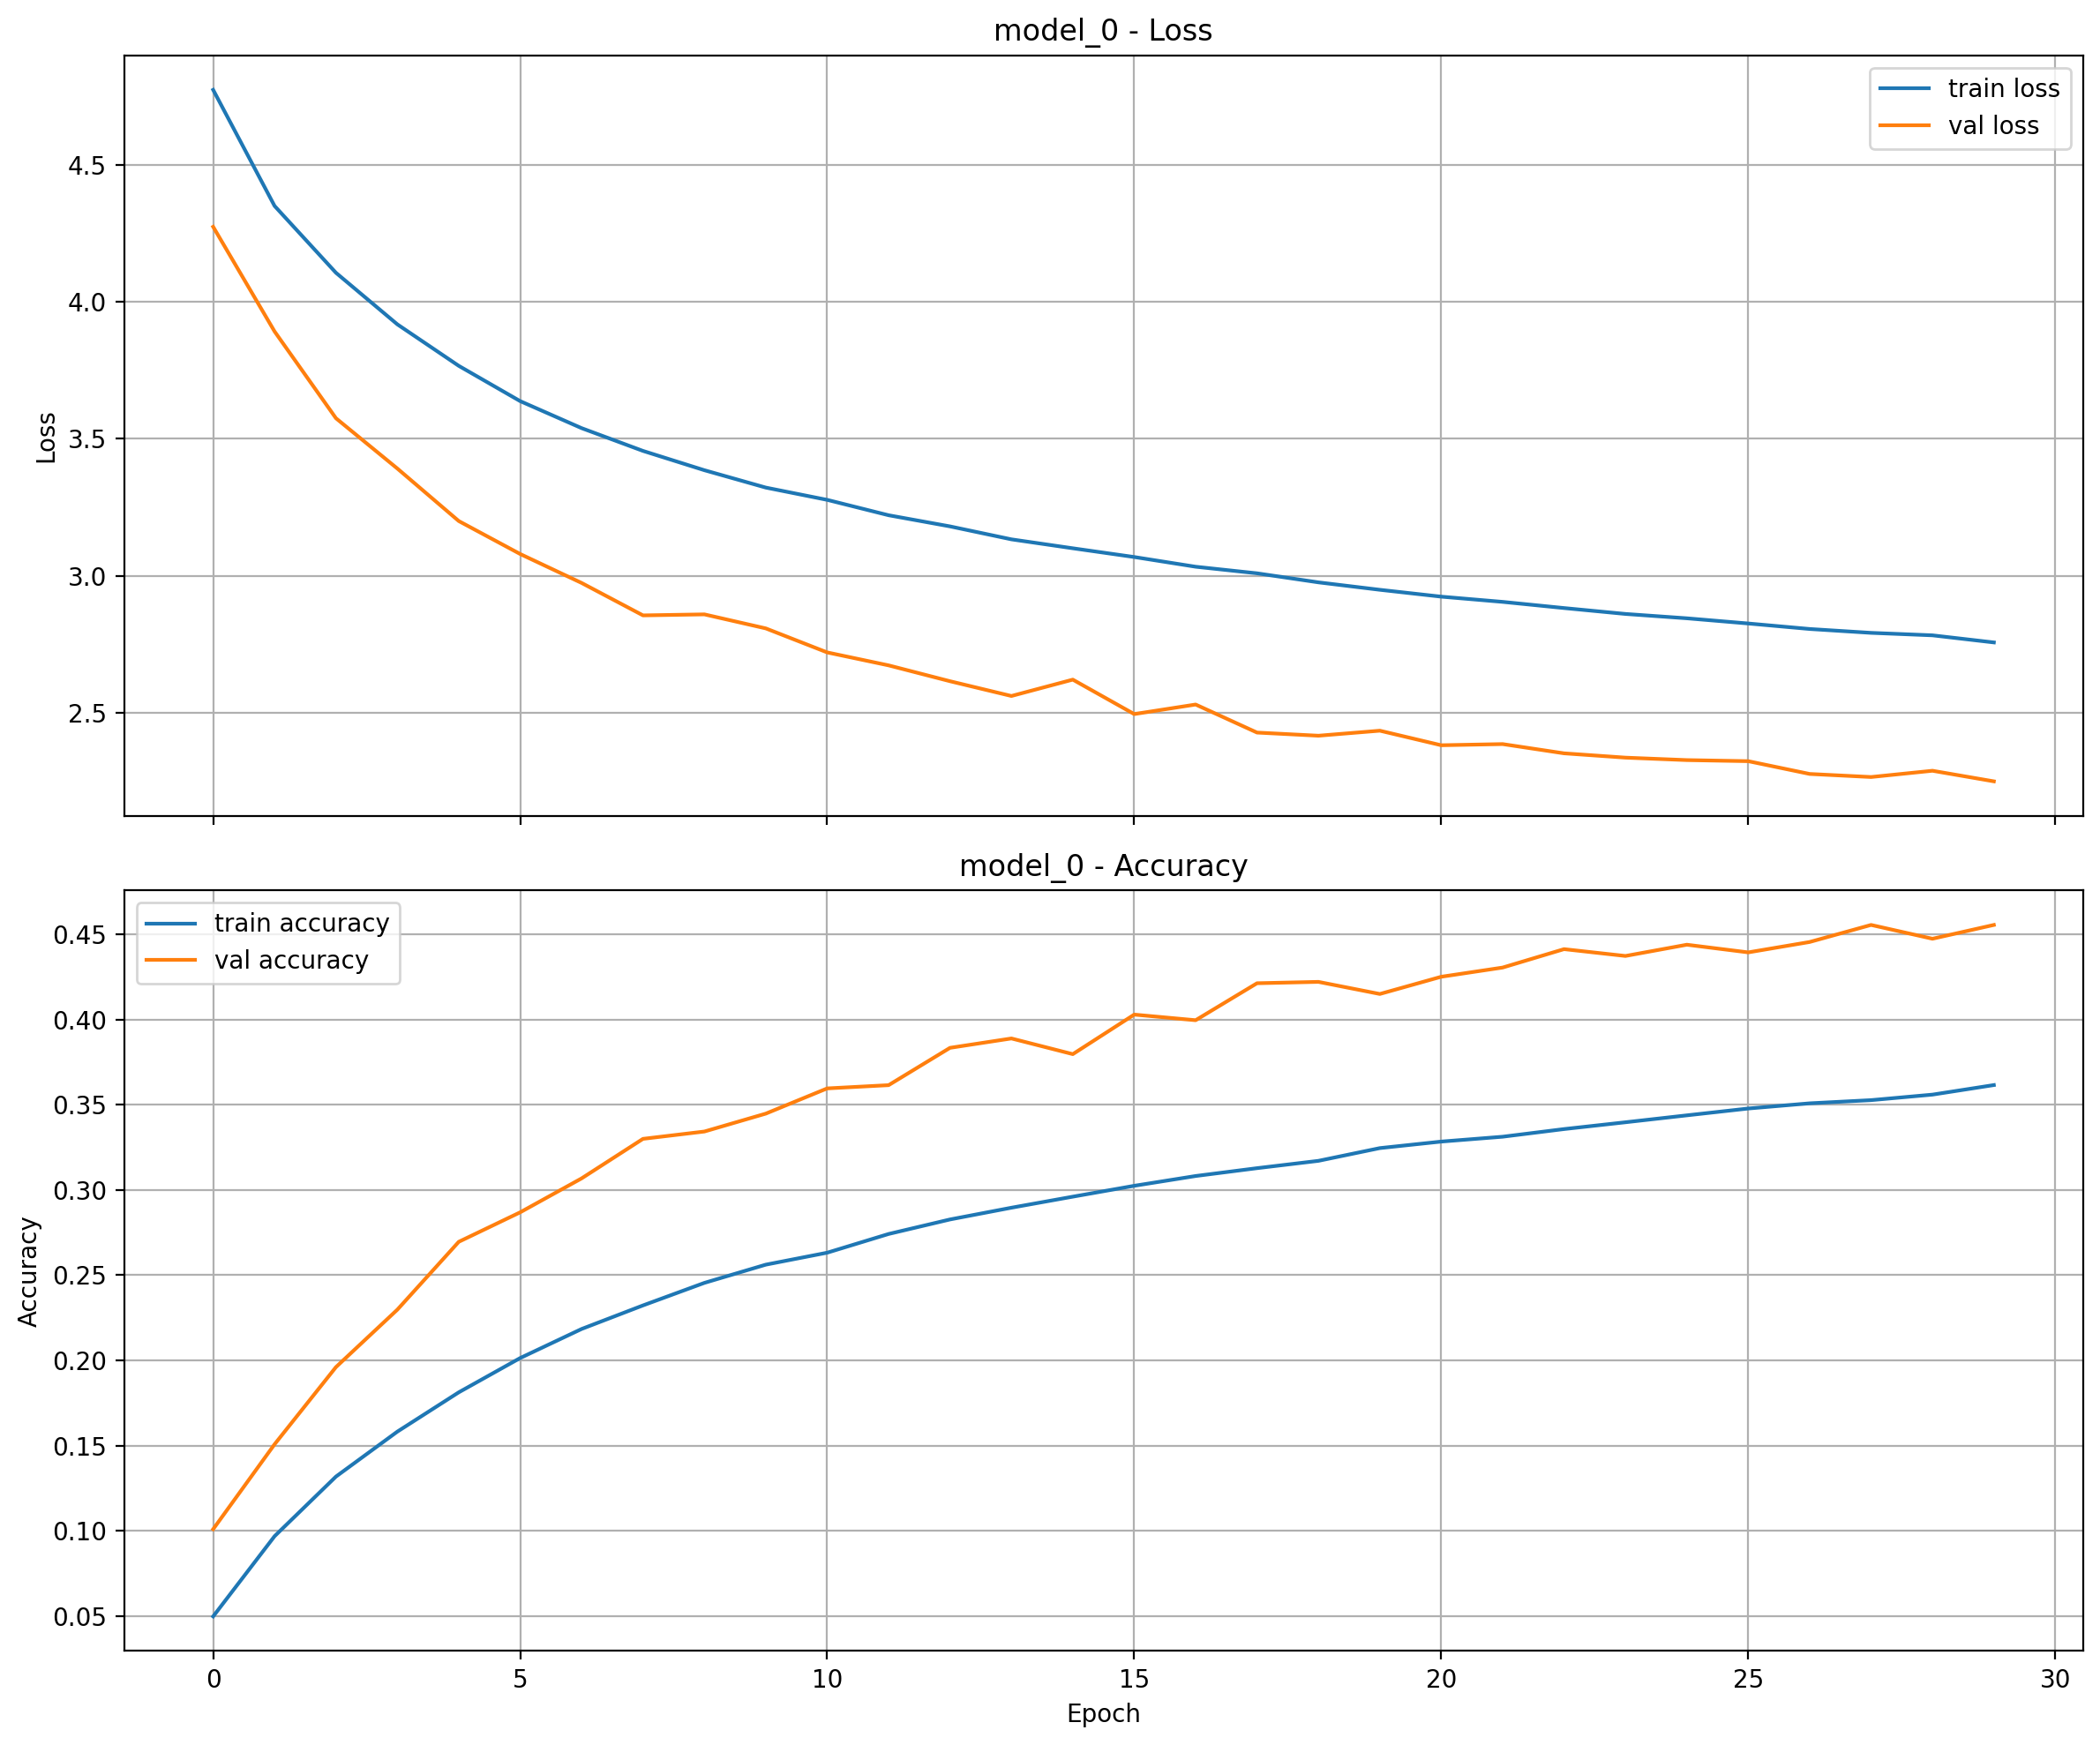

In [ ]:
plot_losses_accuracies(train_losses_0, val_losses_0, train_accuracies_0, val_accuracies_0, title="model_0_aft_30_epochs")

### Вторая модель, достаточно простая модель из статьи:
`https://cs231n.stanford.edu/reports/2016/pdfs/425_Report.pdf`

In [ ]:
config_1 = {
    "learning_rate": 3e-4,
    "weight_decay": 0.01,
    "batch_size": 64,
    "num_epochs": 10,
    "optimizer": torch.optim.AdamW,
    "scheduler": torch.optim.lr_scheduler.LambdaLR
}

train_loader_1 = DataLoader(
    train_dataset,
    batch_size=config_1["batch_size"],
    shuffle=True,
    drop_last=True,
    num_workers=num_workers,
    pin_memory=True,
    prefetch_factor=4,
)

val_loader_1 = DataLoader(
    val_dataset,
    batch_size=config_1["batch_size"],
    shuffle=False,
    drop_last=False,
    num_workers=num_workers,
    pin_memory=True,
    prefetch_factor=4,
)

In [ ]:
class LinearBlock(nn.Module):
    def __init__(self, in_features, out_features, dropout_prob=0.4, is_final=False):
        super(LinearBlock, self).__init__()

        self.linear = nn.Linear(in_features, out_features)
        self.relu_dropout = nn.Sequential(
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_prob)
        ) if not is_final else nn.Identity()

    def forward(self, x):
        x = self.linear(x)
        x = self.relu_dropout(x)
        return x

In [ ]:
model_1 = nn.Sequential(
    CNNBlock(3, 32, kernel_size=5), # 62x62
    CNNBlock(32, 32, kernel_size=5, pool=True), # 30x30
    CNNBlock(32, 64, kernel_size=3),
    CNNBlock(64, 64, kernel_size=3, pool=True), # 15x15
    CNNBlock(64, 64, kernel_size=3),
    CNNBlock(64, 128, kernel_size=3, pool=True), # 7x7

    nn.Flatten(),  # B x 128*7*7

    LinearBlock(128*7*7, 256, dropout_prob=0.3),
    LinearBlock(256, 200, is_final=True),
)

In [ ]:
model_1

Sequential(
  (0): CNNBlock(
    (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): Identity()
  )
  (1): CNNBlock(
    (conv1): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (2): CNNBlock(
    (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): Identity()
  )
  (3): CNNBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, 

In [ ]:
wandb.init(
    # set the wandb project where this run will be logged
    project="HW2",
    name="model_1",
    reinit=True,
    # track hyperparameters and run metadata
    config=config_1,
)

epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
epoch_accuracy_train,▁▂▃▃▄▄▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇███████
epoch_accuracy_val,▁▂▃▄▄▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇█████████
epoch_loss_train,█▇▆▅▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
epoch_loss_val,█▇▆▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
loss,█▇▇▅▄▅▅▅▄▃▄▄▃▃▄▃▂▃▄▃▂▃▃▂▂▄▂▁▃▁▁▂▂▁▂▂▁▁▃▂
lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
training_step,▁▁▂▂▂▂▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇████
epoch,29
epoch_accuracy_train,0.36156
epoch_accuracy_val,0.4555


In [ ]:
optimizer_1 = config_1['optimizer'](model_1.parameters(), lr=config_1['learning_rate'], weight_decay=config_1['weight_decay'])
scheduler_1 = config_1['scheduler'](optimizer_1, lr_lambda=lambda epoch: 1.0)

In [ ]:
train_losses_1, val_losses_1, train_accuracies_1, val_accuracies_1, best_val_loss_1, model_1 = run_experiment(
    model_1,
    train_loader_1,
    val_loader_1,
    loss_fn,
    optimizer_1,
    scheduler_1,
    config_1["num_epochs"],
    device,
    os.path.join(AUX_DATA_ROOT, "checkpoints_1"),
)

epoch: 000 | train: 100%|██████████| 1562/1562 [05:24<00:00,  4.81it/s]
epoch: 000 | val  : 100%|██████████| 157/157 [00:05<00:00, 26.59it/s]


New checkpoint saved to /content/drive/MyDrive/ML3_2024/HW2/checkpoints_1/epoch=00_valloss=5.347.pth.tar



epoch: 001 | train:  74%|███████▍  | 1153/1562 [03:58<01:24,  4.84it/s]


KeyboardInterrupt: 

In [ ]:
plot_losses_accuracies(train_losses_1, val_losses_1, train_accuracies_1, val_accuracies_1, title="model_1")

Видим, что обучается очень плохо - сразу остановим.

### Доучиваем первую модель.

In [ ]:
config_0_1 = {
    "learning_rate": 3e-4,
    "weight_decay": 0.01,
    "batch_size": 50,
    "num_epochs": 70,
    "optimizer": torch.optim.AdamW,
    "scheduler": torch.optim.lr_scheduler.LambdaLR
}

In [ ]:
wandb.init(
    project="HW2",
    id="",
    resume="must",
    reinit=True,
    config=config_0_1,
)

epoch,▁
epoch_accuracy_train,▁
epoch_accuracy_val,▁
epoch_loss_train,▁
epoch_loss_val,▁
loss,▁▂▃▄▆▃▃▆▃▃▅▄▅█▂▅▇▆▄▂▅▆▅▂▆▂▄▅▃▇▂▆▃▁▆▅▄▇▅▄
lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
training_step,▁▁▁▁▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇█████
epoch,0
epoch_accuracy_train,0.00508
epoch_accuracy_val,0.0052


In [25]:
path_to_checkpoints_0 = Path(os.path.join(AUX_DATA_ROOT, "checkpoints_0"))
sorted_files = sorted([f for f in path_to_checkpoints_0.iterdir() if f.is_file()])
best_params_fn = sorted_files[-1] if sorted_files else None
best_params_fn

PosixPath('/content/drive/MyDrive/ML3_2024/HW2/checkpoints_0/epoch=29_valloss=2.251.pth.tar')

In [26]:
model_0 = nn.Sequential(
    CNNBlock(3, 32),
    CNNBlock(32, 32, pool=True), # 32x32
    CNNBlock(32, 64),
    CNNBlock(64, 64, pool=True), # 16x16
    CNNBlock(64, 128),
    CNNBlock(128, 128, pool=True), # 8x8
    CNNBlock(128, 256),
    CNNBlock(256, 256, pool=True), # 4x4
    # v NOTE THIS v
    nn.AdaptiveAvgPool2d((1, 1)),  # B x 256 x 1 x 1
    # ^ NOTE THIS ^
    nn.Flatten(),  # B x 256
    nn.Linear(256, 200)
).to(device)

optimizer_0 = config_0_1['optimizer'](model_0.parameters(), lr=config_0_1['learning_rate'], weight_decay=config_0_1['weight_decay'])
scheduler_0 = config_0_1['scheduler'](optimizer_0, lr_lambda=lambda epoch: 1.0)

In [27]:
best_epoch, best_loss = load_checkpoint(model_0, optimizer_0, scheduler_0, device, best_params_fn)

<ipython-input-16-cd8493b6fbbd>:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(fp, map_location=device)


In [29]:
train_losses_0, val_losses_0, train_accuracies_0, val_accuracies_0, best_val_loss_0, model_0 = run_experiment(
    model_0,
    train_loader_0,
    val_loader_0,
    loss_fn,
    optimizer_0,
    scheduler_0,
    config_0_1["num_epochs"],
    device,
    os.path.join(AUX_DATA_ROOT, "checkpoints_0"),
    start_epoch=best_epoch+1,
    best_val=best_loss
)

epoch: 030 | train: 100%|██████████| 2000/2000 [05:20<00:00,  6.24it/s]
epoch: 030 | val  : 100%|██████████| 200/200 [00:08<00:00, 23.79it/s]


New checkpoint saved to /content/drive/MyDrive/ML3_2024/HW2/checkpoints_0/epoch=30_valloss=2.219.pth.tar



epoch: 031 | train: 100%|██████████| 2000/2000 [05:18<00:00,  6.28it/s]
epoch: 031 | val  : 100%|██████████| 200/200 [00:06<00:00, 32.53it/s]
epoch: 032 | train: 100%|██████████| 2000/2000 [05:22<00:00,  6.20it/s]
epoch: 032 | val  : 100%|██████████| 200/200 [00:08<00:00, 23.93it/s]
epoch: 033 | train: 100%|██████████| 2000/2000 [05:19<00:00,  6.25it/s]
epoch: 033 | val  : 100%|██████████| 200/200 [00:06<00:00, 31.14it/s]


New checkpoint saved to /content/drive/MyDrive/ML3_2024/HW2/checkpoints_0/epoch=33_valloss=2.207.pth.tar



epoch: 034 | train: 100%|██████████| 2000/2000 [05:16<00:00,  6.32it/s]
epoch: 034 | val  : 100%|██████████| 200/200 [00:07<00:00, 25.96it/s]


New checkpoint saved to /content/drive/MyDrive/ML3_2024/HW2/checkpoints_0/epoch=34_valloss=2.186.pth.tar



epoch: 035 | train: 100%|██████████| 2000/2000 [05:19<00:00,  6.25it/s]
epoch: 035 | val  : 100%|██████████| 200/200 [00:06<00:00, 32.69it/s]


New checkpoint saved to /content/drive/MyDrive/ML3_2024/HW2/checkpoints_0/epoch=35_valloss=2.166.pth.tar



epoch: 036 | train: 100%|██████████| 2000/2000 [05:17<00:00,  6.29it/s]
epoch: 036 | val  : 100%|██████████| 200/200 [00:07<00:00, 26.33it/s]
epoch: 037 | train: 100%|██████████| 2000/2000 [05:16<00:00,  6.33it/s]
epoch: 037 | val  : 100%|██████████| 200/200 [00:06<00:00, 28.73it/s]
epoch: 038 | train: 100%|██████████| 2000/2000 [05:17<00:00,  6.29it/s]
epoch: 038 | val  : 100%|██████████| 200/200 [00:06<00:00, 32.86it/s]
epoch: 039 | train: 100%|██████████| 2000/2000 [05:18<00:00,  6.28it/s]
epoch: 039 | val  : 100%|██████████| 200/200 [00:08<00:00, 22.91it/s]
epoch: 040 | train: 100%|██████████| 2000/2000 [05:14<00:00,  6.36it/s]
epoch: 040 | val  : 100%|██████████| 200/200 [00:07<00:00, 26.78it/s]


New checkpoint saved to /content/drive/MyDrive/ML3_2024/HW2/checkpoints_0/epoch=40_valloss=2.149.pth.tar



epoch: 041 | train: 100%|██████████| 2000/2000 [05:17<00:00,  6.29it/s]
epoch: 041 | val  : 100%|██████████| 200/200 [00:05<00:00, 33.98it/s]
epoch: 042 | train: 100%|██████████| 2000/2000 [05:16<00:00,  6.32it/s]
epoch: 042 | val  : 100%|██████████| 200/200 [00:08<00:00, 23.85it/s]


New checkpoint saved to /content/drive/MyDrive/ML3_2024/HW2/checkpoints_0/epoch=42_valloss=2.135.pth.tar



epoch: 043 | train: 100%|██████████| 2000/2000 [05:16<00:00,  6.32it/s]
epoch: 043 | val  : 100%|██████████| 200/200 [00:08<00:00, 22.54it/s]
epoch: 044 | train: 100%|██████████| 2000/2000 [05:17<00:00,  6.29it/s]
epoch: 044 | val  : 100%|██████████| 200/200 [00:05<00:00, 33.97it/s]


New checkpoint saved to /content/drive/MyDrive/ML3_2024/HW2/checkpoints_0/epoch=44_valloss=2.108.pth.tar



epoch: 045 | train: 100%|██████████| 2000/2000 [05:16<00:00,  6.31it/s]
epoch: 045 | val  : 100%|██████████| 200/200 [00:06<00:00, 29.15it/s]


New checkpoint saved to /content/drive/MyDrive/ML3_2024/HW2/checkpoints_0/epoch=45_valloss=2.103.pth.tar



epoch: 046 | train: 100%|██████████| 2000/2000 [05:11<00:00,  6.42it/s]
epoch: 046 | val  : 100%|██████████| 200/200 [00:09<00:00, 21.47it/s]
epoch: 047 | train: 100%|██████████| 2000/2000 [05:11<00:00,  6.42it/s]
epoch: 047 | val  : 100%|██████████| 200/200 [00:07<00:00, 26.36it/s]
epoch: 048 | train: 100%|██████████| 2000/2000 [05:13<00:00,  6.39it/s]
epoch: 048 | val  : 100%|██████████| 200/200 [00:06<00:00, 33.18it/s]
epoch: 049 | train: 100%|██████████| 2000/2000 [05:11<00:00,  6.41it/s]
epoch: 049 | val  : 100%|██████████| 200/200 [00:08<00:00, 23.60it/s]


New checkpoint saved to /content/drive/MyDrive/ML3_2024/HW2/checkpoints_0/epoch=49_valloss=2.066.pth.tar



epoch: 050 | train: 100%|██████████| 2000/2000 [05:11<00:00,  6.43it/s]
epoch: 050 | val  : 100%|██████████| 200/200 [00:07<00:00, 25.86it/s]
epoch: 051 | train: 100%|██████████| 2000/2000 [05:10<00:00,  6.44it/s]
epoch: 051 | val  : 100%|██████████| 200/200 [00:05<00:00, 34.48it/s]
epoch: 052 | train: 100%|██████████| 2000/2000 [05:07<00:00,  6.51it/s]
epoch: 052 | val  : 100%|██████████| 200/200 [00:05<00:00, 34.44it/s]
epoch: 053 | train: 100%|██████████| 2000/2000 [05:08<00:00,  6.49it/s]
epoch: 053 | val  : 100%|██████████| 200/200 [00:06<00:00, 30.19it/s]
epoch: 054 | train: 100%|██████████| 2000/2000 [05:07<00:00,  6.50it/s]
epoch: 054 | val  : 100%|██████████| 200/200 [00:07<00:00, 28.56it/s]


New checkpoint saved to /content/drive/MyDrive/ML3_2024/HW2/checkpoints_0/epoch=54_valloss=2.051.pth.tar



epoch: 055 | train: 100%|██████████| 2000/2000 [05:08<00:00,  6.49it/s]
epoch: 055 | val  : 100%|██████████| 200/200 [00:08<00:00, 22.23it/s]
epoch: 056 | train: 100%|██████████| 2000/2000 [05:06<00:00,  6.52it/s]
epoch: 056 | val  : 100%|██████████| 200/200 [00:08<00:00, 22.94it/s]
epoch: 057 | train: 100%|██████████| 2000/2000 [05:09<00:00,  6.47it/s]
epoch: 057 | val  : 100%|██████████| 200/200 [00:07<00:00, 25.90it/s]


New checkpoint saved to /content/drive/MyDrive/ML3_2024/HW2/checkpoints_0/epoch=57_valloss=2.038.pth.tar



epoch: 058 | train: 100%|██████████| 2000/2000 [05:10<00:00,  6.43it/s]
epoch: 058 | val  : 100%|██████████| 200/200 [00:06<00:00, 32.03it/s]
epoch: 059 | train: 100%|██████████| 2000/2000 [05:12<00:00,  6.39it/s]
epoch: 059 | val  : 100%|██████████| 200/200 [00:05<00:00, 33.90it/s]
epoch: 060 | train: 100%|██████████| 2000/2000 [05:13<00:00,  6.38it/s]
epoch: 060 | val  : 100%|██████████| 200/200 [00:07<00:00, 25.53it/s]
epoch: 061 | train: 100%|██████████| 2000/2000 [05:06<00:00,  6.53it/s]
epoch: 061 | val  : 100%|██████████| 200/200 [00:08<00:00, 22.90it/s]
epoch: 062 | train: 100%|██████████| 2000/2000 [05:07<00:00,  6.51it/s]
epoch: 062 | val  : 100%|██████████| 200/200 [00:08<00:00, 24.42it/s]
epoch: 063 | train: 100%|██████████| 2000/2000 [05:10<00:00,  6.45it/s]
epoch: 063 | val  : 100%|██████████| 200/200 [00:05<00:00, 34.34it/s]
epoch: 064 | train: 100%|██████████| 2000/2000 [05:09<00:00,  6.46it/s]
epoch: 064 | val  : 100%|██████████| 200/200 [00:05<00:00, 33.89it/s]


New checkpoint saved to /content/drive/MyDrive/ML3_2024/HW2/checkpoints_0/epoch=64_valloss=2.037.pth.tar



epoch: 065 | train: 100%|██████████| 2000/2000 [05:10<00:00,  6.44it/s]
epoch: 065 | val  : 100%|██████████| 200/200 [00:08<00:00, 24.47it/s]


New checkpoint saved to /content/drive/MyDrive/ML3_2024/HW2/checkpoints_0/epoch=65_valloss=2.034.pth.tar



epoch: 066 | train: 100%|██████████| 2000/2000 [05:11<00:00,  6.43it/s]
epoch: 066 | val  : 100%|██████████| 200/200 [00:07<00:00, 26.23it/s]


New checkpoint saved to /content/drive/MyDrive/ML3_2024/HW2/checkpoints_0/epoch=66_valloss=2.033.pth.tar



epoch: 067 | train: 100%|██████████| 2000/2000 [05:13<00:00,  6.37it/s]
epoch: 067 | val  : 100%|██████████| 200/200 [00:07<00:00, 25.71it/s]
epoch: 068 | train: 100%|██████████| 2000/2000 [05:22<00:00,  6.19it/s]
epoch: 068 | val  : 100%|██████████| 200/200 [00:05<00:00, 33.55it/s]
epoch: 069 | train: 100%|██████████| 2000/2000 [05:17<00:00,  6.30it/s]
epoch: 069 | val  : 100%|██████████| 200/200 [00:08<00:00, 22.52it/s]


New checkpoint saved to /content/drive/MyDrive/ML3_2024/HW2/checkpoints_0/epoch=69_valloss=2.001.pth.tar

Best val_loss = 2.001 reached at epoch 69


<ipython-input-16-cd8493b6fbbd>:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(fp, map_location=device)


In [30]:
torch.save(model_0.state_dict(), os.path.join(AUX_DATA_ROOT, "model_0"))

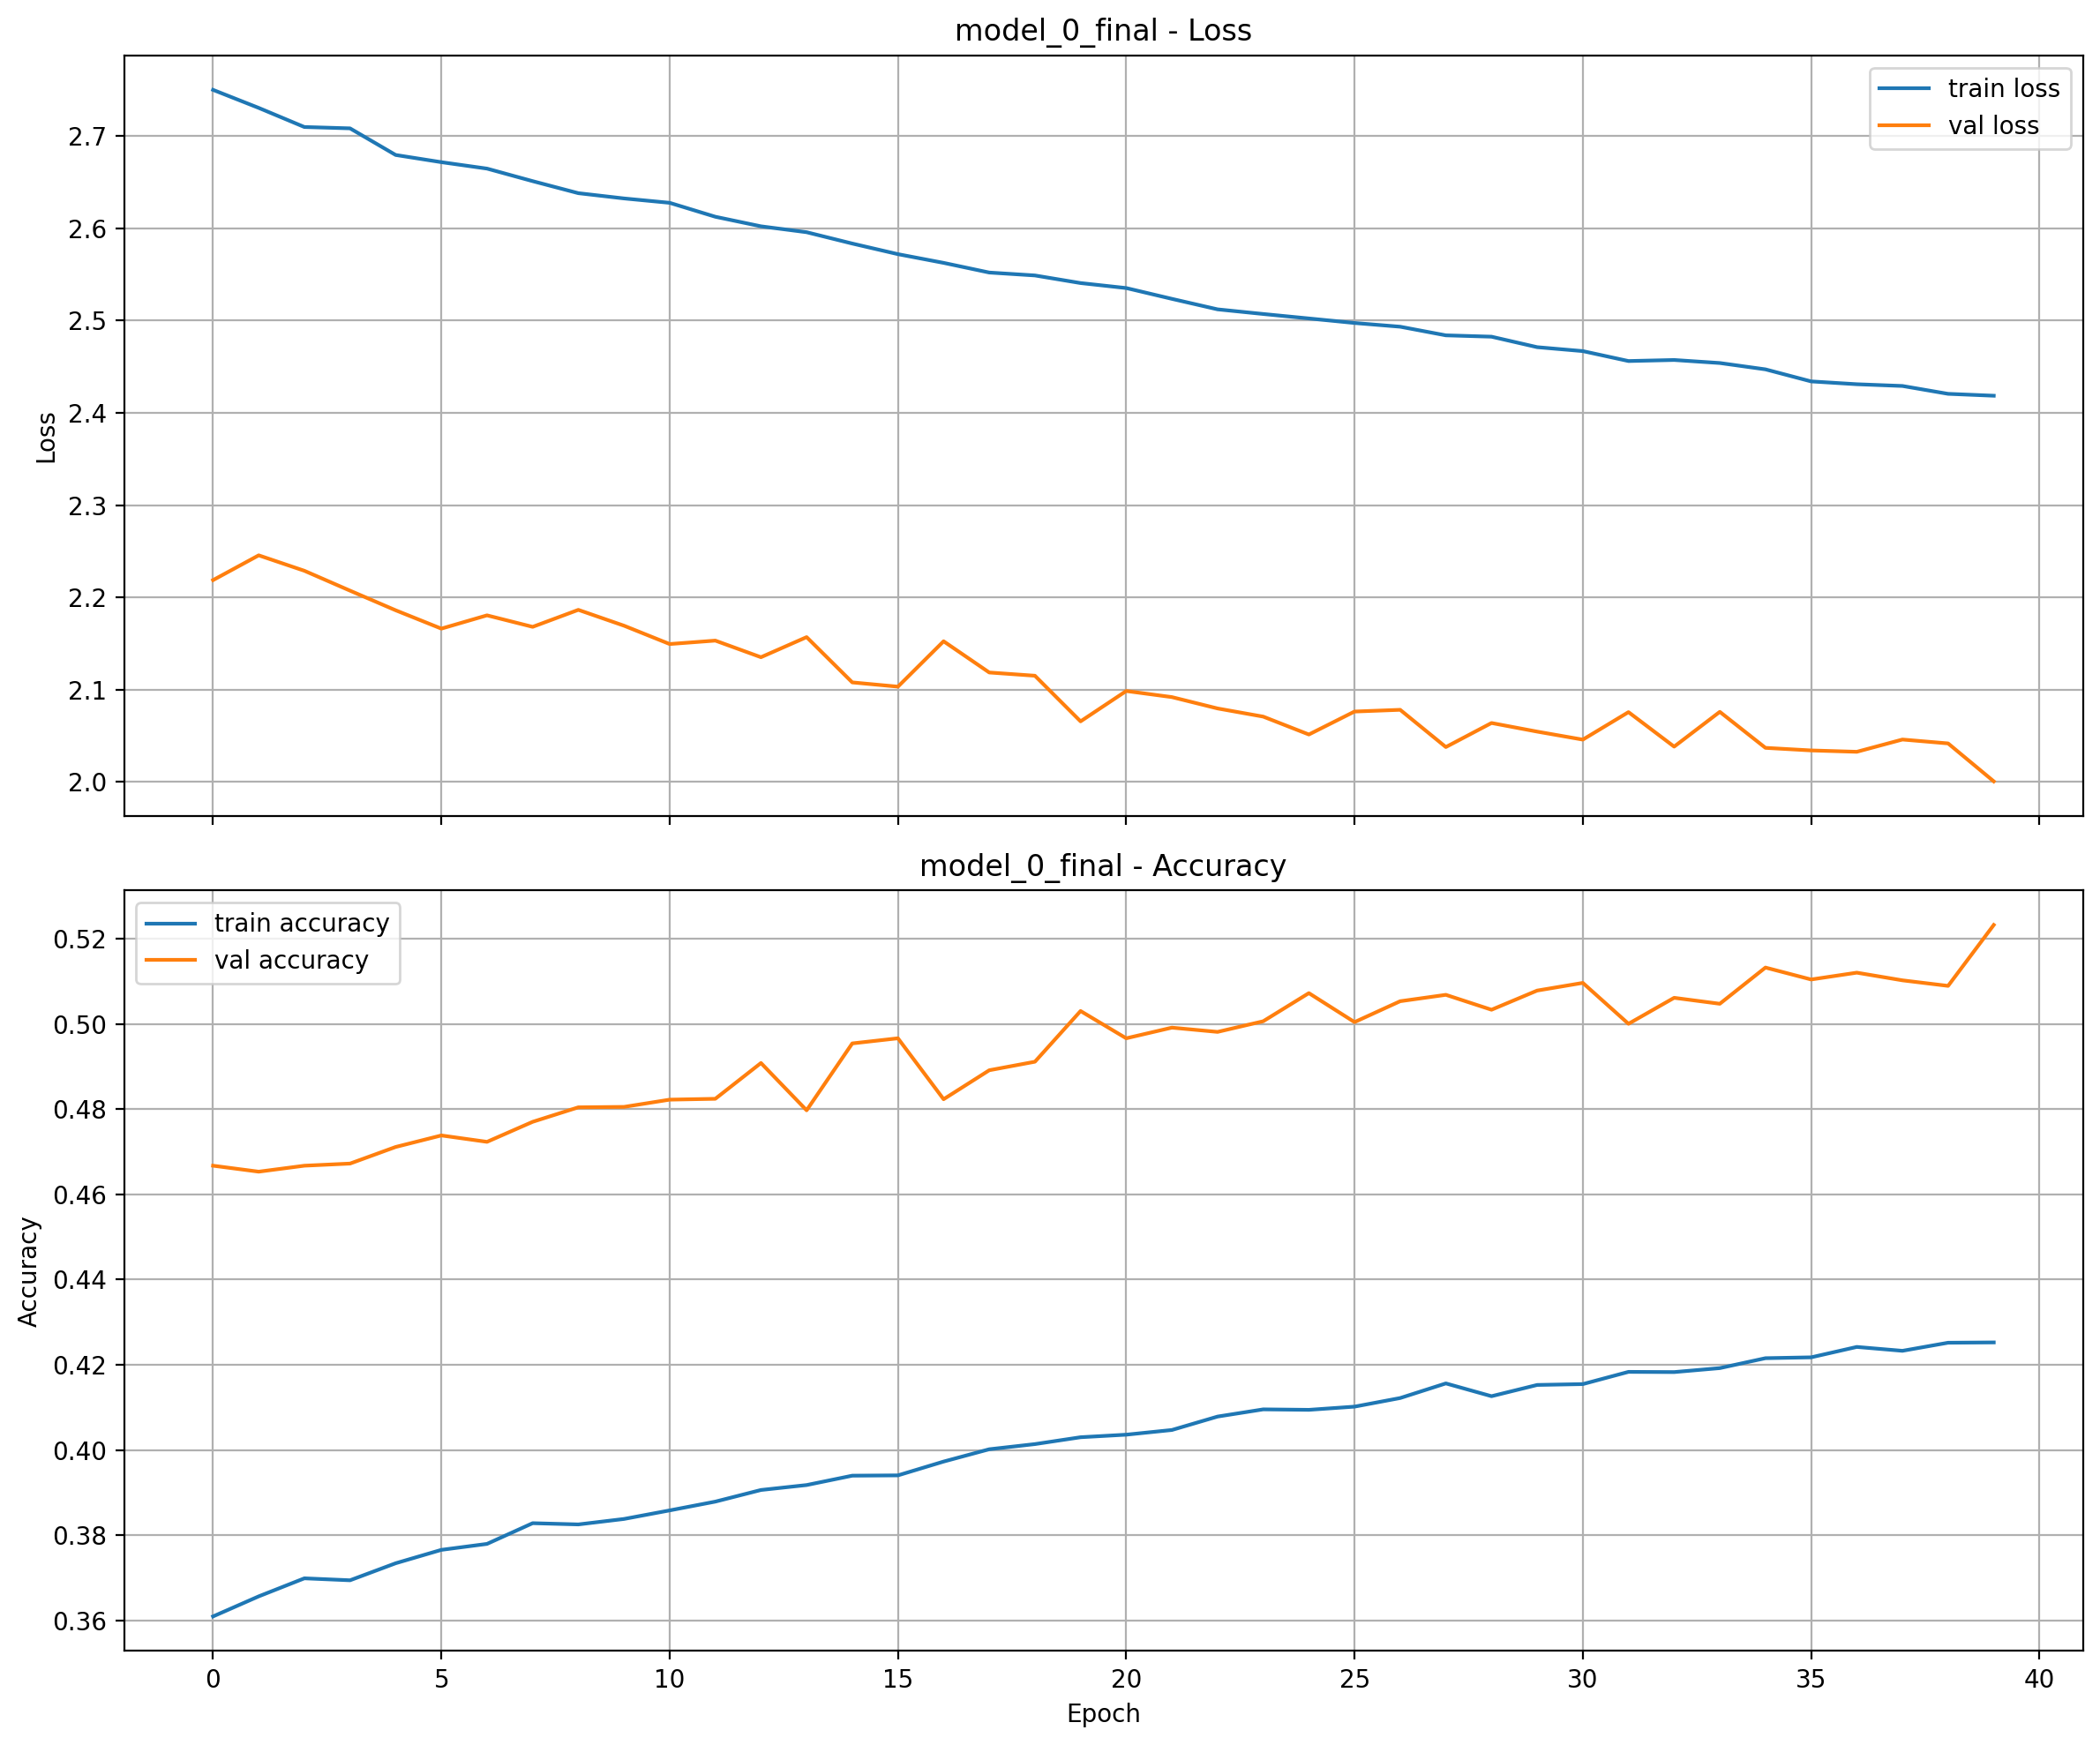

In [31]:
plot_losses_accuracies(train_losses_0, val_losses_0, train_accuracies_0, val_accuracies_0, title="model_0_30-70_epochs")

### Третья модель, модель из статьи `https://www.researchgate.net/publication/332604178_DenseNet_Models_for_Tiny_ImageNet_Classification` будет полностью обучена на каггле.

Дальнейший код для макета обучения, само обучение проводилось на каггле (research_nb_2). Смотреть только его!

In [ ]:
config_2 = {
    "learning_rate": 1e-4,
    "weight_decay": 2e-4,
    "batch_size": 128,
    "num_epochs": 30,
    "optimizer": torch.optim.RMSprop,
    "scheduler": torch.optim.lr_scheduler.CyclicLR
}

train_loader_2 = DataLoader(
    train_dataset,
    batch_size=config_2["batch_size"],
    shuffle=True,
    drop_last=True,
    num_workers=num_workers,
    pin_memory=True,
    prefetch_factor=4,
)

val_loader_2 = DataLoader(
    val_dataset,
    batch_size=config_2["batch_size"],
    shuffle=False,
    drop_last=False,
    num_workers=num_workers,
    pin_memory=True,
    prefetch_factor=4,
)

In [ ]:
class Model_2(nn.Module):
    def __init__(self, num_classes):
        super(Model_2, self).__init__()

        # Block 1
        self.conv1 = CNNBlock(in_channels=3, out_channels=32, kernel_size=3, padding=1, stride=1, pool=False)
        self.skip_connection_1 = None  # Сохраним output этого блока для skip connection

        # Block 2
        self.conv2_1 = CNNBlock(in_channels=32, out_channels=128)
        self.conv2_2 = CNNBlock(in_channels=128, out_channels=128)
        self.conv2_3 = CNNBlock(in_channels=128, out_channels=128)
        self.conv2_4 = CNNBlock(in_channels=128, out_channels=128)

        # Layer after concatenate of Block 1 and Block 2
        self.conv2_5 = CNNBlock(out_channels=160, pool=True, conv=False) # 32 + 128 from concatenation
        self.skip_connection_2 = None  # Для skip connection в следующем блоке

        # Block 3
        self.conv3_1 = CNNBlock(in_channels=160, out_channels=256)
        self.conv3_2 = CNNBlock(in_channels=256, out_channels=256)
        self.conv3_3 = CNNBlock(in_channels=256, out_channels=256)
        self.conv3_4 = CNNBlock(in_channels=256, out_channels=256)

        # Layer after concatenate of Block 2 and Block 3
        self.conv3_5 = CNNBlock(out_channels=416, pool=True, conv=False) # 160 + 256 from concatenation
        self.skip_connection_3 = None

        # Block 4
        self.conv4_1 = CNNBlock(in_channels=416, out_channels=512)
        self.conv4_2 = CNNBlock(in_channels=512, out_channels=512)
        self.conv4_3 = CNNBlock(in_channels=512, out_channels=512)
        self.conv4_4 = CNNBlock(in_channels=512, out_channels=512)

        # Layer after concatenate of Block 3 and Block 4
        self.conv4_5 = CNNBlock(out_channels=928, pool=True, conv=False) # 416 + 512 from concatenation

        # Final layers
        self.conv_final = nn.Conv2d(in_channels=928, out_channels=num_classes, kernel_size=1, padding=0)
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))

    def forward(self, x):
        # Block 1
        x = self.conv1(x)
        self.skip_connection_1 = x  # Сохраняем для skip connection

        # Block 2
        x = self.conv2_1(x)
        x = self.conv2_2(x)
        x = self.conv2_3(x)
        x = self.conv2_4(x)

        # Concatenate skip_connection_1 and output of Block 2
        x = torch.cat([self.skip_connection_1, x], dim=1)
        x = self.conv2_5(x)
        self.skip_connection_2 = x  # Сохраняем для следующей skip connection

        # Block 3
        x = self.conv3_1(x)
        x = self.conv3_2(x)
        x = self.conv3_3(x)
        x = self.conv3_4(x)

        # Concatenate skip_connection_2 and output of Block 3
        x = torch.cat([self.skip_connection_2, x], dim=1)
        x = self.conv3_5(x)
        self.skip_connection_3 = x  # Сохраняем для следующей skip connection

        # Block 4
        x = self.conv4_1(x)
        x = self.conv4_2(x)
        x = self.conv4_3(x)
        x = self.conv4_4(x)

        # Concatenate skip_connection_3 and output of Block 4
        x = torch.cat([self.skip_connection_3, x], dim=1)
        x = self.conv4_5(x)

        # Final layers
        x = self.conv_final(x)
        x = self.global_avg_pool(x)
        x = x.view(x.size(0), -1)  # Разворачиваем для классификационного слоя
        return x

In [ ]:
model_2 = Model_2(200)
model_2

Model_2(
  (conv1): CNNBlock(
    (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): Identity()
  )
  (conv2_1): CNNBlock(
    (conv1): Conv2d(32, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): Identity()
  )
  (conv2_2): CNNBlock(
    (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): Identity()
  )
  (conv2_3): CNNBlock(
    (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_run

In [ ]:
wandb.init(
    # set the wandb project where this run will be logged
    project="HW2",
    name="model_2",
    reinit=True,
    # track hyperparameters and run metadata
    config=config_2,
)

epoch,▁█
epoch_accuracy_train,▁█
epoch_accuracy_val,▁█
epoch_loss_train,█▁
epoch_loss_val,█▁
loss,█▇▅▄▄▄▅▃▄▃▃▃▃▃▄▄▄▃▄▅▄▃▄▂▃▄▂▂▄▄▂▂▁▃▂▃▂▄▃▁
lr,▁▁▁▁▂▂▂▂▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▇███▇▇▅▅▅▅▅▄▄▄▃▃
training_step,▁▁▂▂▂▂▂▂▂▂▃▃▃▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇█████
epoch,1
epoch_accuracy_train,0.05846
epoch_accuracy_val,0.0936


In [ ]:
optimizer_2 = config_2['optimizer'](model_2.parameters(), lr=config_2['learning_rate'], weight_decay=config_2['weight_decay'], eps=1e-8)
scheduler_2 = config_2['scheduler'](optimizer_2, base_lr=config_2['learning_rate'], max_lr=6e-4, step_size_up=4686, mode='triangular2')

In [ ]:
train_losses_2, val_losses_2, train_accuracies_2, val_accuracies_2, best_val_loss_2, model_2 = run_experiment(
    model_2,
    train_loader_2,
    val_loader_2,
    loss_fn,
    optimizer_2,
    scheduler_2,
    config_2["num_epochs"],
    device,
    "/content/drive/MyDrive/ML3_2024/HW2/checkpoints_2",
)

epoch: 000 | train: 100%|██████████| 3125/3125 [09:43<00:00,  5.36it/s]
epoch: 000 | val  : 100%|██████████| 313/313 [00:18<00:00, 16.98it/s]


New checkpoint saved to /content/drive/MyDrive/ML3_2024/HW2/checkpoints/epoch=00_valloss=4.719.pth.tar



epoch: 001 | train: 100%|██████████| 3125/3125 [09:25<00:00,  5.53it/s]
epoch: 001 | val  : 100%|██████████| 313/313 [00:18<00:00, 17.16it/s]


New checkpoint saved to /content/drive/MyDrive/ML3_2024/HW2/checkpoints/epoch=01_valloss=4.554.pth.tar



epoch: 002 | train: 100%|██████████| 3125/3125 [09:20<00:00,  5.58it/s]
epoch: 002 | val  : 100%|██████████| 313/313 [00:17<00:00, 17.82it/s]


New checkpoint saved to /content/drive/MyDrive/ML3_2024/HW2/checkpoints/epoch=02_valloss=4.190.pth.tar



epoch: 003 | train: 100%|██████████| 3125/3125 [09:14<00:00,  5.63it/s]
epoch: 003 | val  : 100%|██████████| 313/313 [00:18<00:00, 17.33it/s]
epoch: 004 | train: 100%|██████████| 3125/3125 [09:20<00:00,  5.57it/s]
epoch: 004 | val  : 100%|██████████| 313/313 [00:18<00:00, 17.13it/s]


New checkpoint saved to /content/drive/MyDrive/ML3_2024/HW2/checkpoints/epoch=04_valloss=4.170.pth.tar



epoch: 005 | train: 100%|██████████| 3125/3125 [09:15<00:00,  5.63it/s]
epoch: 005 | val  : 100%|██████████| 313/313 [00:17<00:00, 17.53it/s]


New checkpoint saved to /content/drive/MyDrive/ML3_2024/HW2/checkpoints/epoch=05_valloss=4.012.pth.tar



epoch: 006 | train: 100%|██████████| 3125/3125 [09:09<00:00,  5.69it/s]
epoch: 006 | val  : 100%|██████████| 313/313 [00:17<00:00, 17.77it/s]
epoch: 007 | train: 100%|██████████| 3125/3125 [09:17<00:00,  5.61it/s]
epoch: 007 | val  : 100%|██████████| 313/313 [00:17<00:00, 17.67it/s]
epoch: 008 | train:   7%|▋         | 227/3125 [00:40<08:58,  5.38it/s]

In [ ]:
plot_losses_accuracies(train_losses_2, val_losses_2, train_accuracies_2, val_accuracies_2, title="model_2")

### Продолжение обучения с фиксированной точки.

In [ ]:
wandb.init(
    project="HW2",
    id="",
    resume="must",
    reinit=True,
    config=config_2,
)

In [ ]:
model_2 = Model_2(200).to(device)
optimizer_2 = config_2['optimizer'](model_2.parameters(), lr=config_2['learning_rate'], weight_decay=config_2['weight_decay'], eps=1e-8)
scheduler_2 = config_2['scheduler'](optimizer_2, base_lr=config_2['learning_rate'], max_lr=6e-4, step_size_up=4686, mode='triangular2')

In [ ]:
path_to_checkpoints_2 = Path(os.path.join(AUX_DATA_ROOT, "checkpoints_2"))
sorted_files = sorted([f for f in path_to_checkpoints_2.iterdir() if f.is_file()])
best_params_fn = sorted_files[-1] if sorted_files else None
best_params_fn

In [ ]:
best_epoch, best_loss = load_checkpoint(model_2, optimizer_2, scheduler_2, best_params_fn)